In [1]:
# Import packages

import pandas as pd
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot
import pickle

In [ ]:
# Load the training and test datasets

parq_file = 'data.parquet'
data = pd.read_parquet(parq_file, 'auto')

parq_file_test = 'test.parquet'
data_test = pd.read_parquet(parq_file_test, 'auto')

In [ ]:
# Training dataset has 666814 rows and 76 columns

data.shape

In [ ]:
# Test dataset has 74091 rows and 74 columns, 2 columns less

data_test.shape

In [ ]:
# Columns not present in the test set will be removed before training the model:
# listing_price_local, sale_time

for i in data.columns:
    if i not in data_test.columns:
        print(i)

In [ ]:
# Check column names, data types, non-null counts

data.info()
data_test.info()

In [ ]:
# Check format of sale_time and local_time to calculate the difference

data['sale_time']

In [ ]:
data['local_time']

In [ ]:
# Replace all None values in sale_time with a placeholder

data["sale_time"].replace({None: "2025-01-01T00:00:00.000-07:00"}, inplace=True)
data["sale_time"]

In [10]:
# Replace all missing values with 'na' which will be encoded

data = data.fillna('na')

# Create a no_hashtags column containing a number of hashtags for that listing 
# which will be used as a variable instead of the hashtags column (easier to measure)

def no_hashtags(hashtags):
    no_hashtags = int(hashtags.size)
    return no_hashtags

data['no_hashtags'] = data.apply(lambda row: no_hashtags(row['hashtags']), axis=1)

# Add a column that contains the time in which the product was sold
# We only care about whether something was sold in 24 hours or not, so the placeholder dates
# will be a lot larger than that

def conversion(sale, local):
    frmt = "%Y-%m-%dT%H:%M:%S.%f%z"
    sold_in = datetime.strptime(sale, frmt) - datetime.strptime(local, frmt)
    return sold_in

data['sold_in'] = data.apply(lambda row: conversion(row['sale_time'], row['local_time']), axis=1)

In [11]:
# Check if the new column generated correctly

data['sold_in']

0        2284 days 04:53:39
1        2368 days 08:57:28
2        2300 days 03:23:21
3        2168 days 00:54:19
4        2108 days 12:03:50
                ...        
666809   2117 days 15:37:58
666810   2275 days 10:02:05
666811   2145 days 03:47:50
666812      6 days 04:42:57
666813   2370 days 06:41:30
Name: sold_in, Length: 666814, dtype: timedelta64[ns]

In [13]:
# Create a column separating listings sold in 24 hours (1) and ones that weren't (0)
# This will be the dependent variable

def separation(sold_in):
    if sold_in <= timedelta(days = 1):
        sold_in_24 = 1
    elif sold_in > timedelta(days = 1):
        sold_in_24 = 0
    return sold_in_24

data['sold_in_24'] = data.apply(lambda row: separation(row['sold_in']), axis=1)

# Check if the calculations were correct

data2 = data[data['sold_in_24'] == 1]
data3 = data2.filter(['local_time', 'sale_time', 'sold_in','sold_in_24'])
data3[0:10]

,local_time,sale_time,sold_in,sold_in_24
29,2018-09-19T03:36:55.000-07:00,2018-09-19T04:15:43.000-07:00,00:38:48,1
216,2019-04-22T16:23:24.000-07:00,2019-04-22T18:02:30.000-07:00,01:39:06,1
217,2019-03-17T18:44:38.000-07:00,2019-03-18T15:44:10.000-07:00,20:59:32,1
274,2019-01-22T19:57:58.000-07:00,2019-01-23T08:45:58.000-07:00,12:48:00,1
277,2018-08-17T19:00:16.000-07:00,2018-08-17T21:58:46.000-07:00,02:58:30,1
294,2019-02-17T15:22:28.000-07:00,2019-02-17T17:42:59.000-07:00,02:20:31,1
369,2018-09-15T20:31:26.000-07:00,2018-09-15T23:26:25.000-07:00,02:54:59,1
383,2019-03-22T20:46:35.000-07:00,2019-03-22T20:55:01.000-07:00,00:08:26,1
515,2018-07-05T21:01:38.000-07:00,2018-07-05T21:03:32.000-07:00,00:01:54,1
527,2019-02-27T17:40:49.000-07:00,2019-02-27T20:41:10.000-07:00,03:00:21,1


In [ ]:
# See all columns and what their values are to determine which columns should already be dropped

pd.set_option('display.max_columns', None)

In [ ]:
# data[0:10]

In [14]:
# Drop columns that should not contribute to success of a listing, to ease the training process
# Listing_price_local is removed because test set doesn't have this column

data = data.drop(['title','listing_price_local', 'portal','sold_in', 'brand_is_verified', 'hashtags', 'local_time', 'sale_time'], axis = 1)
data = data.drop(data.loc[:,'custom_shipping_price_domestic':'disposal_conditions'].columns, axis = 1)
data = data.drop(data.loc[:, 'basic_verification_local_time':'lifetime'].columns, axis = 1)
data = data.drop(data.loc[:, 'phone_verification_local_time':'second_sale_local_time'].columns, axis = 1)
data = data.drop(data.loc[:, 'registration_app_id':'registration_type'].columns, axis = 1)

# Change the boolean "True" or "False" column into 1 and 0
        
data['with_video'] = data['with_video']*1

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666814 entries, 0 to 666813
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   brand                          666814 non-null  object 
 1   catalog_code_1                 666814 non-null  object 
 2   catalog_code_2                 666814 non-null  object 
 3   catalog_code_3                 666814 non-null  object 
 4   catalog_code_4                 666814 non-null  object 
 5   catalog_code_5                 666814 non-null  object 
 6   color_primary                  666814 non-null  object 
 7   color_secondary                666814 non-null  object 
 8   disposal_conditions_string     666814 non-null  object 
 9   listing_platform               666814 non-null  object 
 10  package_size_code              666814 non-null  object 
 11  size                           666814 non-null  object 
 12  with_video                    

In [15]:
# Turn object data type columns into categories and then encode each category 
# so all variables are numeric

for col_name in data.columns:
    if(data[col_name].dtype == 'object'):
        data[col_name]= data[col_name].astype('category')
        data[col_name] = data[col_name].cat.codes

In [16]:
# Check how the dataset looks now
# Only float and integer columns left which the model will be able to handle

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666814 entries, 0 to 666813
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   brand                          666814 non-null  int16  
 1   catalog_code_1                 666814 non-null  int8   
 2   catalog_code_2                 666814 non-null  int8   
 3   catalog_code_3                 666814 non-null  int16  
 4   catalog_code_4                 666814 non-null  int16  
 5   catalog_code_5                 666814 non-null  int8   
 6   color_primary                  666814 non-null  int8   
 7   color_secondary                666814 non-null  int8   
 8   disposal_conditions_string     666814 non-null  int8   
 9   listing_platform               666814 non-null  int8   
 10  package_size_code              666814 non-null  int8   
 11  size                           666814 non-null  int16  
 12  with_video                    

In [17]:
# Assign independent (X) and dependent (y) variables

y = data.pop('sold_in_24')
X = data

In [18]:
# Split the data into training, test and validation sets

seed = 50

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state = seed)

In [19]:
# Create and fit Random Forest model

model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = seed)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [20]:
# Make predictions on the validation set

y_pred = model.predict(X_val)

In [22]:
# Model evaluation / Confusion Matrix

from sklearn.metrics import confusion_matrix

confusion_m_val = confusion_matrix(y_val, y_pred)
confusion_m_val

array([[103662,    269],
       [  2417,    343]])

In [23]:
# Accuracy, Precision, Recall and F1 scores


accuracy_val = accuracy_score(y_val, y_pred)
print("accuracy:", accuracy_val)

precision_val = precision_score(y_val, y_pred)
print("precision:", precision_val)

recall_val = recall_score(y_val, y_pred)
print("recall:", recall_val)

f1_val = f1_score(y_val, y_pred)
print("f1:", f1_val)

accuracy: 0.9748244931624973
precision: 0.5604575163398693
recall: 0.12427536231884058
f1: 0.20344009489916962


In [24]:
# Save this model

pickle.dump(model, open('baseline_model.pkl','wb'))

Feature: 0, Score: 0.05189
Feature: 1, Score: 0.00264
Feature: 2, Score: 0.01109
Feature: 3, Score: 0.03475
Feature: 4, Score: 0.04616
Feature: 5, Score: 0.00344
Feature: 6, Score: 0.04094
Feature: 7, Score: 0.03116
Feature: 8, Score: 0.00281
Feature: 9, Score: 0.00657
Feature: 10, Score: 0.00790
Feature: 11, Score: 0.03745
Feature: 12, Score: 0.00035
Feature: 13, Score: 0.04571
Feature: 14, Score: 0.03739
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00125
Feature: 17, Score: 0.00147
Feature: 18, Score: 0.02779
Feature: 19, Score: 0.05195
Feature: 20, Score: 0.07541
Feature: 21, Score: 0.00701
Feature: 22, Score: 0.03240
Feature: 23, Score: 0.02389
Feature: 24, Score: 0.04870
Feature: 25, Score: 0.02033
Feature: 26, Score: 0.04929
Feature: 27, Score: 0.04257
Feature: 28, Score: 0.01169
Feature: 29, Score: 0.00561
Feature: 30, Score: 0.03212
Feature: 31, Score: 0.01499
Feature: 32, Score: 0.06353
Feature: 33, Score: 0.01108
Feature: 34, Score: 0.04849
Feature: 35, Score: 0.04966
Fe

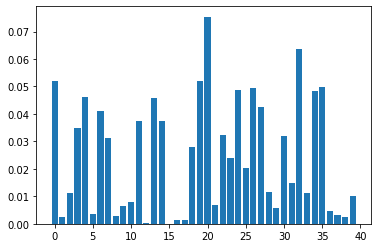

In [25]:
# Find scores that show how important each feature is

importance = model.feature_importances_

importances_dict = {}

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    importances_dict[i] = v

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [27]:
# Find how many are above >= 0.01

top = []

for i in importance:
    if i >= 0.01:
        top.append(i)

amount_top_features = len(top)
print(amount_top_features)

26


In [30]:
# Sort features and extract top (scores >=  0.01)

sorted_features = sorted(importances_dict.items(), key = lambda x: x[1], reverse = True)

sorted_features_top = sorted_features[0:26]

top_features = []

for i in sorted_features_top:
    top_features.append(i[0])

# Find feature names

column_numbers = {}

for i,v in enumerate(data.columns):
    column_numbers[i] = v

# Match feature names and numbers
    
top_features_numbered = {}

for i in top_features:
    top_features_numbered[i] = column_numbers.get(i)
    

# Extract top feature names
    
top_important_features = []

for i in top_features_numbered.values():
    top_important_features.append(i)
    
top_important_features

['lister_nth_listing',
 'window_gmv_sold',
 'lister_nth_day_of_listing',
 'brand',
 'window_items_sold',
 'total_items_listed',
 'total_gmv_sold',
 'window_items_listed',
 'catalog_code_4',
 'birthday',
 'total_items_sold',
 'color_primary',
 'size',
 'city',
 'catalog_code_3',
 'total_feedback_count',
 'total_positive_feedback_count',
 'color_secondary',
 'state',
 'total_gmv_bought',
 'total_items_bought',
 'window_gmv_bought',
 'total_negative_feedback_count',
 'catalog_code_2',
 'window_items_bought',
 'no_hashtags']

In [31]:
# Select only important features for a new training/test set

X_train = X_train[top_important_features]
X_test = X_test[top_important_features]

In [32]:
# Retrain the model using important features

model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = seed)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=50, verbose=0,
                       warm_start=False)

In [33]:
# Make predictions on the test set

y_pred_test = model.predict(X_test)

In [34]:
# Model evaluation / Confusion Matrix

confusion_m_test = confusion_matrix(y_test, y_pred_test)
confusion_m_test

array([[129547,    311],
       [  3095,    410]])

In [37]:
# Model evaluation and comparison / Accuracy, Precision, Recall, F1

accuracy_test = accuracy_score(y_test, y_pred_test)
print("Validation accuracy:", accuracy_val)
print("Test accuracy:", accuracy_test)

precision_test = precision_score(y_test, y_pred_test)
print("Validation precision:", precision_val)
print("Test precision:", precision_test)

recall_test = recall_score(y_test, y_pred_test)
print("Validation recall:", recall_val)
print("Test recall:", recall_test)

f1_test = f1_score(y_test, y_pred_test)
print("Validation f1:", f1_val)
print("Test f1:", f1_test)

Validation accuracy: 0.9748244931624973
Test accuracy: 0.9744606824981442
Validation precision: 0.5604575163398693
Test precision: 0.5686546463245492
Validation recall: 0.12427536231884058
Test recall: 0.11697574893009986
Validation f1: 0.20344009489916962
Test f1: 0.19403691433980122


In [38]:
# Save this model

pickle.dump(model, open('top_features_model.pkl','wb'))

In [39]:
# Prepare final test data

# Replace all missing values with 'na' which will be encoded

data_test = data_test.fillna('na')

# Create a no_hashtags column containing a number of hashtags for that listing 
# which will be used as a variable instead of the hashtags column (easier to measure)

def no_hashtags(hashtags):
    no_hashtags = int(hashtags.size)
    return no_hashtags

data_test['no_hashtags'] = data_test.apply(lambda row: no_hashtags(row['hashtags']), axis=1)

In [40]:
# Select only the top important features for the test set

X_test_final = data_test[top_important_features]

In [41]:
# Encode all object variables

for col_name in X_test_final.columns:
    if(X_test_final[col_name].dtype == 'object'):
        X_test_final[col_name]= X_test_final[col_name].astype('category')
        X_test_final[col_name] = X_test_final[col_name].cat.codes

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74091 entries, 0 to 74090
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   lister_nth_listing             74091 non-null  int32  
 1   window_gmv_sold                74091 non-null  float64
 2   lister_nth_day_of_listing      74091 non-null  int32  
 3   brand                          74091 non-null  int16  
 4   window_items_sold              74091 non-null  int64  
 5   total_items_listed             74091 non-null  int64  
 6   total_gmv_sold                 74091 non-null  float64
 7   window_items_listed            74091 non-null  int64  
 8   catalog_code_4                 74091 non-null  int16  
 9   birthday                       74091 non-null  int16  
 10  total_items_sold               74091 non-null  int64  
 11  color_primary                  74091 non-null  int8   
 12  size                           74091 non-null 

In [43]:
model = pickle.load(open('top_features_model.pkl', 'rb'))

In [44]:
# Make predictions on the test set

y_pred_final = model.predict(X_test_final)

In [45]:
# Add a predictions column to the test data then filter the rows that were predicted to be sold within 24 hours

X_test_final['predicted_label'] = y_pred_final

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
X_final = X_test_final[X_test_final['predicted_label'] == 1]

In [47]:
# 51 lines of the test dataset were predicted to be sold within 24 hours

X_final.shape

(51, 27)

In [48]:
# Drop the added column and save the dataframe

X_test_final = X_test_final.drop(['predicted_label'], axis = 1)

X_test_final.to_parquet('predictions.parquet')